In [1]:
import spacedecomp
from spacedecomp.kernels import RBF, Matern, Periodic
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.distributions import MultivariateNormal


'''
Tutorial inspired on http://pyro.ai/examples/gp.html, to test our library
'''

'\nTutorial inspired on http://pyro.ai/examples/gp.html, to test our library\n'

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
kernels = [RBF, Matern, Periodic]

## Sample from sine function with noise

$Y = 2sin(3*X) + 0.4\epsilon $

$\epsilon \sim N(0, 1)$

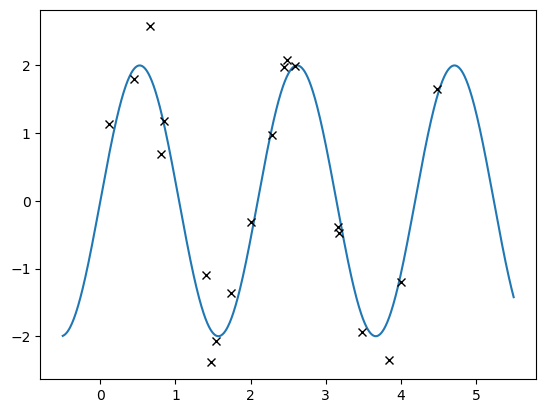

In [3]:
torch.manual_seed(0)

N = 20
X = 5*torch.rand((N,))
y = 2 *torch.sin(3 * X) + 0.4*torch.randn((N,))

Nsamples = 1000
Xtest = torch.linspace(-0.5, 5.5, Nsamples, dtype=torch.float)


plt.plot(Xtest, 2*torch.sin(3*Xtest))
plt.plot(X, y, "kx")

### Test samples of using different variance and lenghtscales

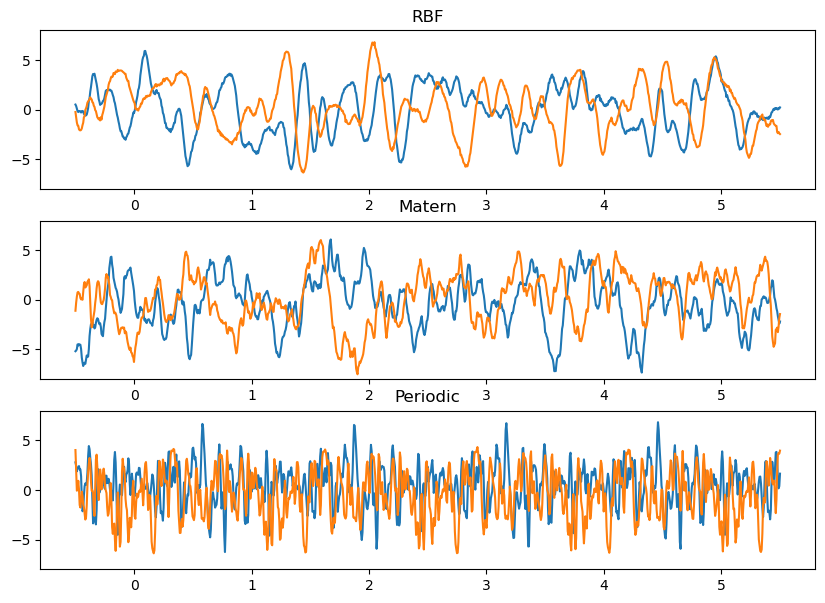

In [4]:
plt.figure(figsize=(10, 7))

for i, kernel_class in enumerate(kernels):

    kernel = kernel_class(
    variance=6.0, lengthscale= 0.05 )
    
    gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
    cov = kernel.predict(X=Xtest[:, None]) + (gpr.noise**2)*torch.eye(Nsamples)
    L = torch.linalg.cholesky(cov)
    samples = MultivariateNormal(torch.zeros(Nsamples), scale_tril=L).sample((3,))
    
    plt.subplot(len(kernels), 1, i+1)
    plt.plot(Xtest, samples[0])
    plt.plot(Xtest, samples[1])
    plt.title(kernel_class.__name__)
    plt.ylim((-8, 8))

### using bigger lengthscale

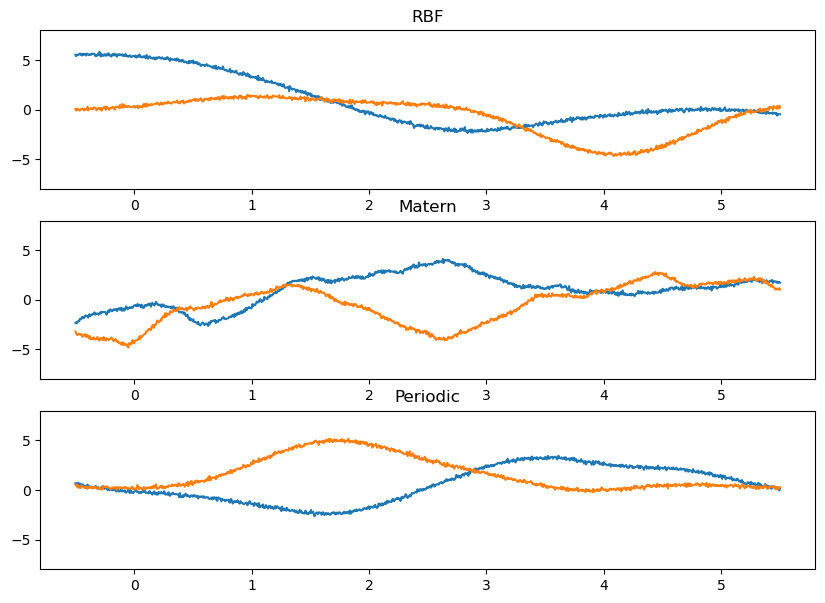

In [5]:
plt.figure(figsize=(10, 7))

for i, kernel_class in enumerate(kernels):

    kernel = kernel_class(
    variance=6.0, lengthscale= 1 )

    
    gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
    cov = kernel.predict(X=Xtest[:, None]) + (gpr.noise**2)*torch.eye(Nsamples)
    samples = MultivariateNormal(torch.zeros(Nsamples),cov).sample((3,))
    
    plt.subplot(len(kernels), 1, i+1)
    plt.plot(Xtest, samples[0])
    plt.plot(Xtest, samples[1])
    plt.title(kernel_class.__name__)
    plt.ylim((-8, 8))

### smaller variance, bigger lengthscale

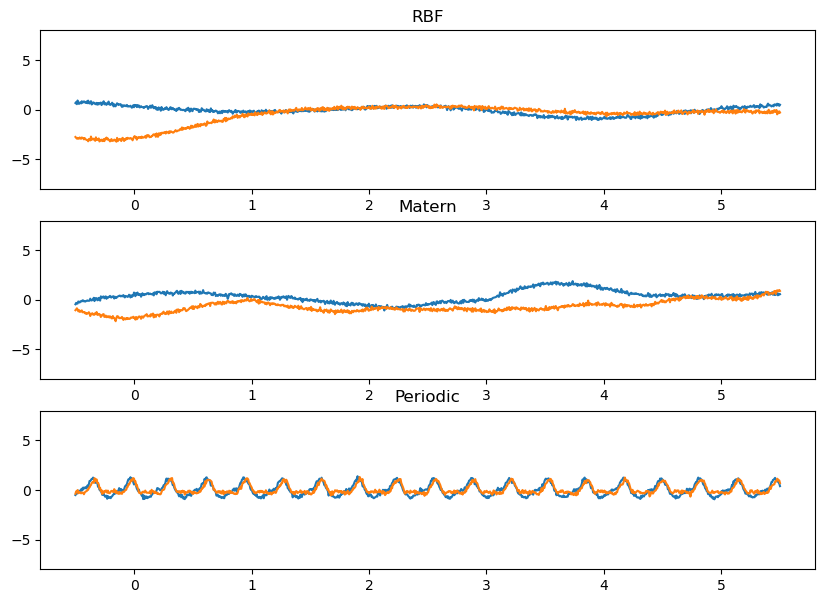

In [6]:
plt.figure(figsize=(10, 7))

for i, kernel_class in enumerate(kernels):

    kernel = kernel_class(
    variance=1, lengthscale= 1 )

    
    gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
    cov = kernel.predict(X=Xtest[:, None]) + (gpr.noise**2)*torch.eye(Nsamples)
    samples = MultivariateNormal(torch.zeros(Nsamples),cov).sample((3,))
    
    plt.subplot(len(kernels), 1, i+1)
    plt.plot(Xtest, samples[0])
    plt.plot(Xtest, samples[1])
    plt.title(kernel_class.__name__)
    plt.ylim((-8, 8))

## Train GP

Finished Training


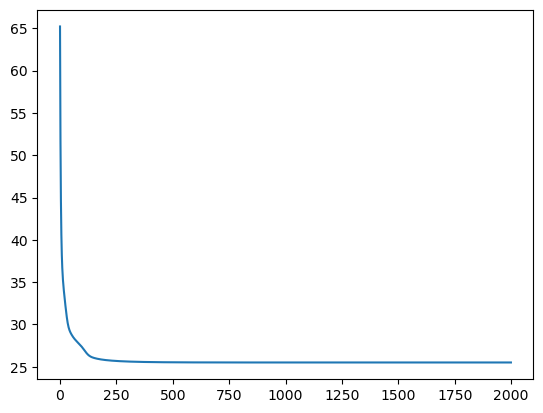

In [7]:
kernel = RBF()
gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
history = gpr.fit(optimizer=optim.Adam, epochs=2000, lr=1e-2)
plt.plot(history)

## Get posterior distribution

In [8]:
Nsamples = 200
Xtest = torch.linspace(-0.5, 5.5, Nsamples)
with torch.no_grad():
    mean, cov = gpr.predict(Xtest[:,None])
    sd = cov.diag().sqrt()
    mean = mean

mean:  torch.Size([200])
covariance:  torch.Size([200, 200])


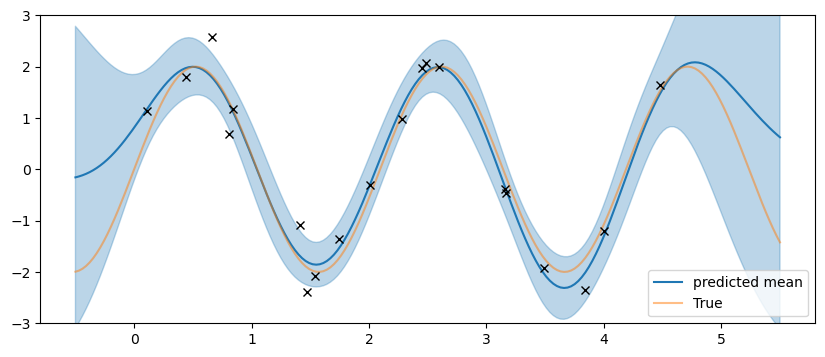

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(Xtest, mean, label='predicted mean')
plt.plot(Xtest, 2*np.sin(3*Xtest), alpha=0.5, label='True')
plt.fill_between(
            Xtest,
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
plt.plot(X, y, "kx")
plt.ylim((-3, 3))
plt.legend()

### Visualize sampled functions

In [10]:
with torch.no_grad():
    posterior_cov = cov + (1e-2**2)*torch.eye(Nsamples) #add small noise for it to be PD
    L = torch.linalg.cholesky(posterior_cov)
    posterior_dist = MultivariateNormal(mean, scale_tril=L)

(-3.0, 3.0)

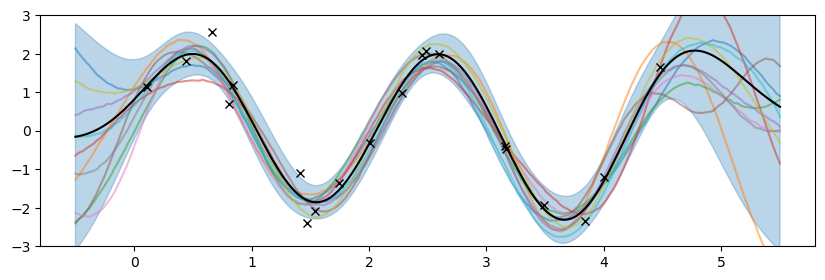

In [11]:
N_functions = 10
samples = posterior_dist.sample((N_functions,))

plt.figure(figsize=(10, 3))
plt.fill_between(
            Xtest,
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
        
for i in range(N_functions):
    plt.plot(Xtest, samples[i], alpha=0.5)


plt.plot(X, y, "kx")
plt.plot(Xtest, mean, color='black')
plt.ylim((-3, 3))

### Learned noise and variance are similar to the real noise and variance

In [12]:
gpr.noise

tensor(0.4206, requires_grad=True)

In [13]:
gpr.kernel.sigma

tensor([[1.9243]], requires_grad=True)